In [1]:
# Clone the CKAN repository into Kaggle's writable working directory
!git clone https://github.com/AntonioTepsich/ckan.git /kaggle/working/Convolutional-KANs

# Change the current working directory to the cloned repository
%cd /kaggle/working/Convolutional-KANs

Cloning into '/kaggle/working/Convolutional-KANs'...
remote: Enumerating objects: 2379, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2379 (delta 266), reused 311 (delta 196), pack-reused 1970 (from 1)
Receiving objects: 100% (2379/2379), 45.65 MiB | 35.12 MiB/s, done.
Resolving deltas: 100% (1286/1286), done.
/kaggle/working/Convolutional-KANs


In [2]:
# Import PyTorch core modules for neural network operations
import torch
import torch.nn as nn
import torch.nn.functional as F  # Functional operations like activation functions
import torch.optim as optim  # Optimization algorithms (e.g., Adam)

# Import torchvision utilities for dataset handling and transformations
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST  # Fashion MNIST dataset loader

# Import data loading and splitting utilities
from torch.utils.data import DataLoader, random_split

# Import the custom KAN convolutional layer from the cloned repository
from kan_convolutional.KANConv import KAN_Convolutional_Layer

# Import sklearn metrics for evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Import numpy for numerical operations and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

# Import learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# Define the KANC_MLP class inheriting from PyTorch's nn.Module
class KANC_MLP(nn.Module):
    def __init__(self, grid_size: int = 5):
        super().__init__()  # Initialize the parent nn.Module class
        
        # First KAN convolutional layer: 1 input channel (grayscale) to 5 output channels
        self.conv1 = KAN_Convolutional_Layer(
            in_channels=1,          # Fashion MNIST is grayscale
            out_channels=5,
            kernel_size=(3,3),
            grid_size=grid_size     # Controls the complexity of KAN approximation
        )
        
        # Second KAN convolutional layer: 5 input channels to 5 output channels
        self.conv2 = KAN_Convolutional_Layer(
            in_channels=5,
            out_channels=5,
            kernel_size=(3,3),
            grid_size=grid_size
        )
        
        # Max pooling layer to reduce spatial dimensions by half
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Flatten layer to convert 2D feature maps to 1D vector
        self.flat = nn.Flatten()
        
        # Fully connected layer: 125 input features (5x5x5) to 10 output classes
        self.linear1 = nn.Linear(125, 10)  # Matches Fashion MNIST 28x28 input
        
        # Model name for identification
        self.name = f"KANC MLP (Small) (gs = {grid_size})"

    # Forward pass definition
    def forward(self, x):
        x = self.conv1(x)      # Apply first KAN convolution
        x = self.pool1(x)      # Apply pooling
        x = self.conv2(x)      # Apply second KAN convolution
        x = self.pool1(x)      # Apply pooling again
        x = self.flat(x)       # Flatten the feature maps
        # Uncomment below to debug tensor dimensions if needed
        # print(x.shape)
        x = self.linear1(x)    # Apply fully connected layer
        x = F.log_softmax(x, dim=1)  # Apply log softmax for classification
        return x

In [4]:
# Define training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),          # Randomly rotate images by ±10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),                  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))    # Normalize to [-1, 1] range
])

# Define test transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset into Kaggle's writable directory
full_train_dataset = FashionMNIST(root='/kaggle/working/data', train=True, download=True, transform=train_transform)
test_dataset = FashionMNIST(root='/kaggle/working/data', train=False, download=True, transform=test_transform)

# Split training data into 80% train and 20% validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # Training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)    # Validation data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)  # Test data

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.1MB/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]


Extracting /kaggle/working/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



In [5]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the selected device
model = KANC_MLP(grid_size=5).to(device)

# Define cross-entropy loss function for classification
criterion = nn.CrossEntropyLoss()

# Set up Adam optimizer with initial learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configure learning rate scheduler to reduce LR on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # Reduce LR by 0.5 if no improvement

# Print the device being used for confirmation
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Set number of training epochs to 1 as requested
epochs = 10

# Lists to store metrics for plotting
train_losses = []       # Training loss per epoch
val_losses = []         # Validation loss per epoch
val_accuracies = []     # Validation accuracy per epoch
learning_rates = []     # Learning rate per epoch

# Training loop over specified epochs
for epoch in range(epochs):
    # Set model to training mode
    model.train()
    train_loss = 0.0
    
    # Iterate over training batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()         # Clear previous gradients
        outputs = model(images)       # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()               # Backward pass
        optimizer.step()              # Update weights
        train_loss += loss.item()     # Accumulate loss
    
    # Calculate and store average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Set model to evaluation mode for validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Validation phase (no gradient computation)
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
            total += labels.size(0)                   # Total samples
            correct += (predicted == labels).sum().item()  # Correct predictions
    
    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Get and store current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, LR: {current_lr:.6f}")

Epoch [1/10]
Train Loss: 0.8509, Val Loss: 0.6800, Val Accuracy: 74.29%, LR: 0.001000
Epoch [2/10]
Train Loss: 0.6508, Val Loss: 0.6401, Val Accuracy: 75.47%, LR: 0.001000
Epoch [3/10]
Train Loss: 0.6070, Val Loss: 0.5973, Val Accuracy: 77.46%, LR: 0.001000
Epoch [4/10]
Train Loss: 0.5843, Val Loss: 0.5960, Val Accuracy: 77.22%, LR: 0.001000
Epoch [5/10]
Train Loss: 0.5618, Val Loss: 0.5615, Val Accuracy: 79.12%, LR: 0.001000
Epoch [6/10]
Train Loss: 0.5501, Val Loss: 0.5452, Val Accuracy: 79.37%, LR: 0.001000
Epoch [7/10]
Train Loss: 0.5336, Val Loss: 0.5482, Val Accuracy: 79.54%, LR: 0.001000
Epoch [8/10]
Train Loss: 0.5250, Val Loss: 0.5312, Val Accuracy: 80.60%, LR: 0.001000
Epoch [9/10]
Train Loss: 0.5167, Val Loss: 0.5184, Val Accuracy: 81.17%, LR: 0.001000
Epoch [10/10]
Train Loss: 0.5103, Val Loss: 0.5059, Val Accuracy: 80.99%, LR: 0.001000



Test set:
Accuracy: 83.64%
Precision: 0.84
Recall: 0.84
F1 Score: 0.83


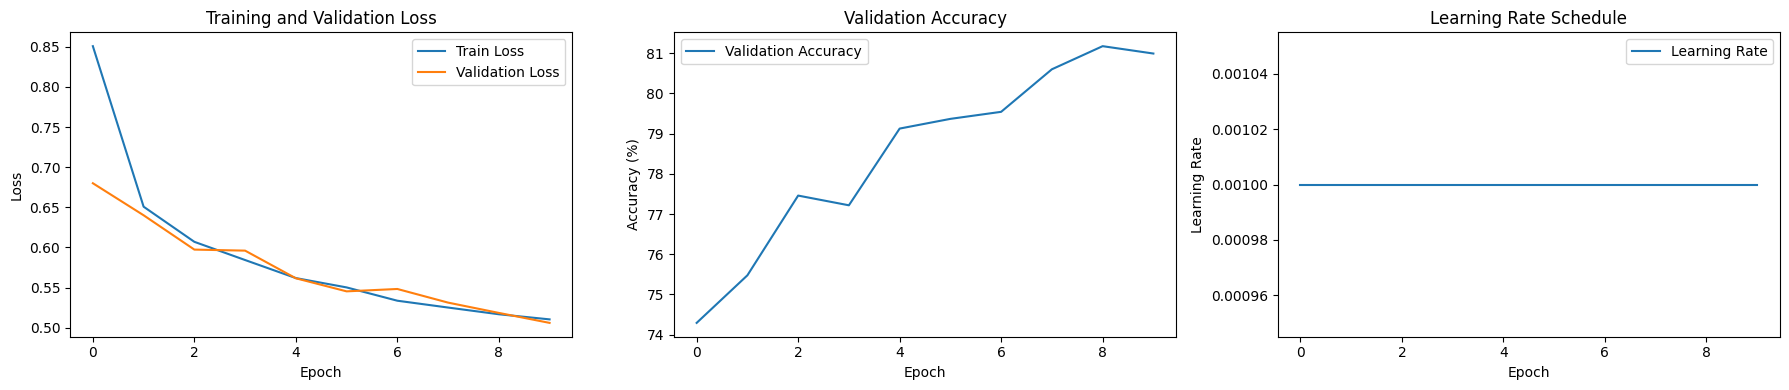

In [7]:
# Set model to evaluation mode for testing
model.eval()
test_loss = 0
correct = 0
all_targets = []        # Store true labels
all_predictions = []    # Store predicted labels

# Test phase (no gradient computation)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()  # Accumulate test loss
        _, predicted = torch.max(outputs.data, 1)       # Get predictions
        correct += (labels == predicted).sum().item()   # Count correct predictions
        all_targets.extend(labels.cpu().numpy())        # Store targets
        all_predictions.extend(predicted.cpu().numpy()) # Store predictions

# Calculate test metrics
test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / len(test_loader.dataset)
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')

# Print test results
print('\nTest set:')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Create visualization of training progress
plt.figure(figsize=(18, 4))  # Set figure size for three subplots

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation accuracy
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule')

# Adjust layout and display plots
plt.tight_layout()
plt.show()